In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, probplot
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

sns.set_theme()
plt.rcParams['figure.dpi'] = 100

# Table Of Contents
1. [Target Variable And Outliers](#Target) 
2. [Imputation Of Missing Values](#Impute)
3. [Near-Zero Variance and Data Transformation](#DataTrans)
4. [Train/Test Split](#TrainTestSplit)
5. [Modeling](#Modeling)
    1. [Models Setup](#Setup)
    2. [Fitting The Models](#fit)
6. [Submission](#submit)

In [3]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

#Save the 'Id' column for submission
train_ID = df_train['Id']
test_ID = df_test['Id']

# drop Id column as it's irrerelvant for the analysis
df_train = df_train.drop(['Id'], axis=1)
df_test = df_test.drop(['Id'], axis=1)

print(f'df_train: {df_train.shape}')
print(f'df_test: {df_test.shape}')

df_train.head(10)

df_train: (1460, 80)
df_test: (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


<a id = "Target"></a>

# Target Variable And Outliers

First let's check if there are any outliers present in the dataset. After a brief research GrLivArea and LotArea were found to have some values that lie way beyond the majority of data points. In order to visualize them let's plot their distribution with respect to the target variable. 

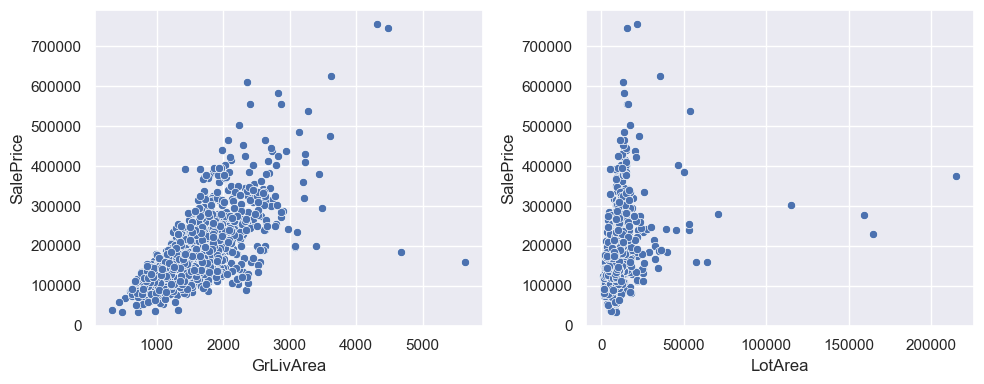

In [4]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))

sns.scatterplot(x=df_train.GrLivArea, y=df_train.SalePrice, ax=ax[0])
sns.scatterplot(x=df_train.LotArea, y=df_train.SalePrice, ax=ax[1])

fig.tight_layout()

Now we define which points to get rid of.

1. **GrLivArea**: remove observations for which living areas are higher than 4000 square feet and the cost is lower than 300000. These points are also considered to be outliers by the documentation for the dataset, thus removed.
2. **LotArea**: remove observations for lot area higher than 50000 square feet. Considering thier average price and large lot area these observations most likely refer to coutry side and are not representative for this data set. Therefore, they're excluded.

In [5]:
# Delete outliers
df_train = df_train.drop(df_train[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 300000)].index)
df_train = df_train.drop(df_train[df_train['LotArea'] > 50000].index)
df_train.reset_index(drop=True, inplace=True)

The next step is to look into the distribution of the target variable SalePrice.

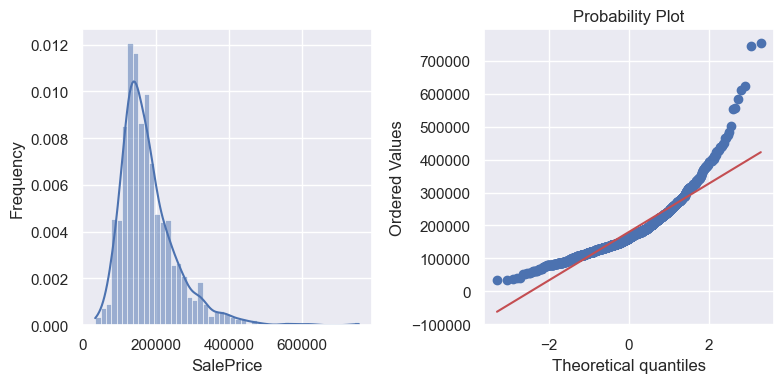

In [6]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

sns.histplot(data = df_train, x=df_train.SalePrice, kde=True, stat='frequency', ax=ax[0])
res = probplot(df_train.SalePrice, plot=ax[1])

fig.tight_layout()

SalePrice is clearly skewed to the right and generaly does not show normality. That can be a bumer as most of the ML models work poorly with non-normal data. In order to fix this we apply log(x+1) transformation.

In [7]:
# log transform of target feature
df_train.SalePrice = np.log1p(df_train.SalePrice)

Now let's check it again.

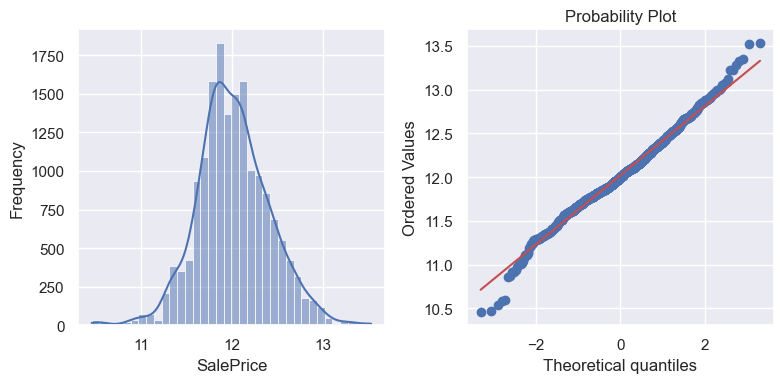

In [8]:
fig, ax = plt.subplots(1,2, figsize=(8,4))

sns.histplot(data = df_train, x=df_train.SalePrice, kde=True, stat='frequency', ax=ax[0])
res = probplot(df_train.SalePrice, plot=ax[1])

fig.tight_layout()

After transformation **SalePrice** is normaly distibuted.

Another interesting thing to look at is the correlation among our features. To see it we construct correlation matrix.

10 the most correlated featuers relative to SalePrice:
SalePrice       1.00
OverallQual     0.83
GrLivArea       0.72
GarageCars      0.68
GarageArea      0.66
TotalBsmtSF     0.64
1stFlrSF        0.62
FullBath        0.60
YearBuilt       0.59
YearRemodAdd    0.57
Name: SalePrice, dtype: float64


<AxesSubplot:title={'center':'10 the most correlated features relative to SalePrice'}>

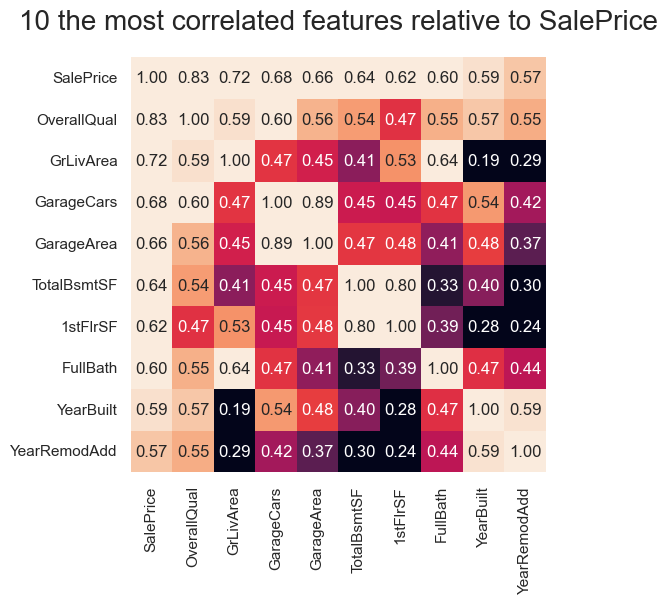

In [9]:
# k the most correlated features relative to SalePrice
k = 10

# create correlation matrix sorted by SalePrice 
corrmat = df_train.corr().sort_values(['SalePrice'], ascending=False)
klargest = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
corr_k = corrmat.loc[klargest, klargest]
print(f'{k} the most correlated featuers relative to SalePrice:\n{corr_k.SalePrice.round(2)}')

# Visualize the result using heatmap
f, ax = plt.subplots(figsize=(k*.55, k*.55))
ax.set_title(f'{k} the most correlated features relative to SalePrice', 
             fontdict={'fontsize':20}, 
             pad=20)

sns.heatmap(
    data=corr_k,
    annot=True,
    fmt='.2f',
    square=True,
    vmin=.3,
    vmax=.6,
    cbar=False)

Knowledge of which features correlate the most with **SalePrice** shows us to which variables we should pay attention.

Now we combine train and test sets into one big set in order to perform some feature engineering.

In [9]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
y_train = df_train.SalePrice

# combine the data
all_data = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
all_data = all_data.drop(['SalePrice'], axis=1)
print(f'Shape of the combined dataset: {all_data.shape}')

Shape of the combined dataset: (2907, 79)


<a id = "Impute"></a>

# Imputation Of Missing Values

Missing values can harm the learning process, therefore we try either replace them with meaningful values (imputation) or, if imputation is not possible, completely get rid of them.
First of all, let's create a function that prints out the variable name along with the number of missing values it contains.

In [10]:
def showNAfeatures(df):
    '''Prints which features of <df> data frame have NA along with the number of NA for each feature'''
    
    if df.isnull().sum().max() > 0:
        for feature in df.columns:
            n_nan = df[feature].isnull().sum()
            if n_nan > 0:
                print(f'{feature}: {n_nan}')
    else:
        print('No NA values found!')

In [11]:
# Show missing values
showNAfeatures(all_data)

MSZoning: 4
LotFrontage: 480
Alley: 2709
Utilities: 2
Exterior1st: 1
Exterior2nd: 1
MasVnrType: 24
MasVnrArea: 23
BsmtQual: 81
BsmtCond: 82
BsmtExposure: 82
BsmtFinType1: 79
BsmtFinSF1: 1
BsmtFinType2: 80
BsmtFinSF2: 1
BsmtUnfSF: 1
TotalBsmtSF: 1
Electrical: 1
BsmtFullBath: 2
BsmtHalfBath: 2
KitchenQual: 1
Functional: 2
FireplaceQu: 1420
GarageType: 157
GarageYrBlt: 159
GarageFinish: 159
GarageCars: 1
GarageArea: 1
GarageQual: 159
GarageCond: 159
PoolQC: 2898
Fence: 2336
MiscFeature: 2804
SaleType: 1


It seems there is a handfull of variables with missing values. After studying the dataset it becomes clear that most of the variables can be treated by imputation as in most of the cases NA values simply indicate absence of a particular category in the example.

*Example*:
        
       Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access

In [12]:
# Data imputing for categorical features
# I thank @JULIENCS and @SERIGNE  for this imputation scripts: 
# https://www.kaggle.com/code/juliencs/a-study-on-regression-applied-to-the-ames-dataset
# https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard#Stacked-Regressions-to-predict-House-Prices

# Alley : data description says NA means "no alley access"
all_data["Alley"] = all_data["Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
all_data["BedroomAbvGr"] = all_data["BedroomAbvGr"].fillna(0)
# BsmtQual, etc : data description says NA for basement features is "no basement"
all_data["BsmtQual"] = all_data["BsmtQual"].fillna("No")
all_data["BsmtCond"] = all_data["BsmtCond"].fillna("No")
all_data["BsmtExposure"] = all_data["BsmtExposure"].fillna("No")
all_data["BsmtFinType1"] = all_data["BsmtFinType1"].fillna("No")
all_data["BsmtFinType2"] = all_data["BsmtFinType2"].fillna("No")
all_data["BsmtFullBath"] = all_data["BsmtFullBath"].fillna(0)
all_data["BsmtHalfBath"] = all_data["BsmtHalfBath"].fillna(0)
all_data["BsmtUnfSF"] = all_data["BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
all_data["CentralAir"] = all_data["CentralAir"].fillna("No")
# Condition : NA most likely means Normal
all_data["Condition1"] = all_data["Condition1"].fillna("Norm")
all_data["Condition2"] = all_data["Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
all_data["EnclosedPorch"] = all_data["EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
all_data["ExterCond"] = all_data["ExterCond"].fillna("TA")
all_data["ExterQual"] = all_data["ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
all_data["Fence"] = all_data["Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("No")
all_data["Fireplaces"] = all_data["Fireplaces"].fillna(0)
# Functional : data description says NA means typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
all_data["GarageType"] = all_data["GarageType"].fillna("No")
all_data["GarageFinish"] = all_data["GarageFinish"].fillna("No")
all_data["GarageQual"] = all_data["GarageQual"].fillna("No")
all_data["GarageCond"] = all_data["GarageCond"].fillna("No")
all_data["GarageArea"] = all_data["GarageArea"].fillna(0)
all_data["GarageCars"] = all_data["GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
all_data["HalfBath"] = all_data["HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
all_data["HeatingQC"] = all_data["HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
all_data["KitchenAbvGr"] = all_data["KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
all_data["KitchenQual"] = all_data["KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
all_data["LotFrontage"] = all_data["LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
all_data["LotShape"] = all_data["LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("No")
all_data["MiscVal"] = all_data["MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
all_data["OpenPorchSF"] = all_data["OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
all_data["PavedDrive"] = all_data["PavedDrive"].fillna("No")
# PoolQC : data description says NA means "no pool"
all_data["PoolQC"] = all_data["PoolQC"].fillna("No")
all_data["PoolArea"] = all_data["PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
all_data["SaleCondition"] = all_data["SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
all_data["ScreenPorch"] = all_data["ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
all_data["TotRmsAbvGrd"] = all_data["TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
all_data["Utilities"] = all_data["Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
all_data["WoodDeckSF"] = all_data["WoodDeckSF"].fillna(0)
# replace missing values with 'RL' as the most common value
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
# replace Exterior1st/2nd with the most common value as it's only 1 missing value for each feature
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
# replace with 0 as most probably missing value means no basement here
all_data['BsmtFinSF1'] = all_data['BsmtFinSF1'].fillna(0)
all_data['BsmtFinSF2'] = all_data['BsmtFinSF1'].fillna(0)
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].fillna(0)
# fill with the most common 'WD'
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
# fill with the most common 'SBrkr'
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [13]:
# Some numerical features are actually really categories
all_data = all_data.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [14]:
# Encode some categorical features as ordered numbers when there is information in the order
all_data = all_data.replace({"Alley" : {"None": 0, "Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "CentralAir": {"N": 0, "Y": 1},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

Now let's check how much of the missing data was eliminated by imputing.

In [15]:
showNAfeatures(all_data)

GarageYrBlt: 159


It was quite effective! The remaining feature is **GarageYrBlt**.

As in most of the cases the year a house was built will match the year the garage for this house was built, we approximate the missing values for **GarageYrBlt** with the ones from **YearBuilt**.

In [16]:
# replace NA values in GarageYrBlt with values from YearBuilt
all_data['GarageYrBlt'].fillna(all_data['YearBuilt'], inplace=True)

In [17]:
showNAfeatures(all_data)

No NA values found!


<a id = "DataTrans"></a>

# Near-Zero Variance and Data Transformation

The goal of this seciton is to analyze and process numerical features. 
After studying the dataset we identified that the following features are numerical:
        
        LotFrontage
        LotArea
        YearBuilt
        YearRemodAdd
        MasVnrArea
        BsmtFinSF1
        BsmtFinSF2
        BsmtUnfSF
        TotalBsmtSF
        1stFlrSF
        2ndFlrSF
        GrLivArea
        GarageYrBlt
        GarageArea
        WoodDeckSF
        OpenPorchSF
        EnclosedPorch
        3SsnPorch
        ScreenPorch


In [18]:
# List of numerical features we are going to analyze and transform if needed
numerical = ['LotFrontage',
        'LotArea',
        'YearBuilt',
        'YearRemodAdd',
        'MasVnrArea',
        'BsmtFinSF1',
        'BsmtFinSF2',
        'BsmtUnfSF',
        'TotalBsmtSF',
        '1stFlrSF',
        '2ndFlrSF',
        'GrLivArea',
        'GarageYrBlt',
        'GarageArea',
        'WoodDeckSF',
        'OpenPorchSF',
        'EnclosedPorch',
        '3SsnPorch',
        'ScreenPorch',
]

Calculate their Skewness and Kurtosis to check whether a particular feature is a subject for the transformation.

In [19]:
# Skew and Kurtosis for each feature from <numerical> sorted by their skewness
measures = pd.DataFrame(data = {'Before/After':'Before transform',
                                'Skew':all_data[numerical].skew(),
                                'Kurtosis':all_data[numerical].kurt()},
                       ).sort_values(by='Skew', ascending=False)

In [20]:
measures

,Before/After,Skew,Kurtosis
3SsnPorch,Before transform,11.357997,148.778343
EnclosedPorch,Before transform,3.997514,28.263920
ScreenPorch,Before transform,3.952944,17.827037
LotArea,Before transform,2.718926,17.075099
MasVnrArea,Before transform,2.632012,9.534872
OpenPorchSF,Before transform,2.536796,11.074035
WoodDeckSF,Before transform,1.806955,6.610212
1stFlrSF,Before transform,1.270257,5.159915
GrLivArea,Before transform,1.069698,2.461007
BsmtFinSF2,Before transform,0.986905,1.465503


It seems that some of the features have quite extreme measures, so we will manually investigate them one by one to find what might be a reason of such behavior.

Beside skewness and kurtosis we calculate mode and percentage of data occupied by the mode (to identify the case of near-zero variance). And just like we did with the target variable we visualize data by drawing distribution and probability plots to have a clear picture of which steps we should take in order to process the data.

*We do the mentioned steps for all features but to save space in this notebook the results are showed only for **GrLivArea** variable.*

Skew: 1.07
Kurtosis: 2.46
Mode: 864.00 (1.41%)
Ratio: 1.6


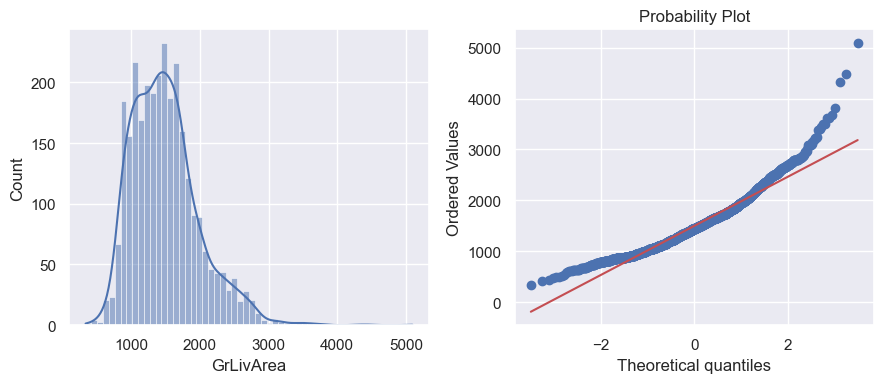

In [21]:
# variable under investigation
var = 'GrLivArea'

# Mode of the variable
var_mode = all_data[var].mode()[0]

# ratio of the first two most frequent values
vals = all_data[var].value_counts().values[:2].tolist()
ratio = vals[0]/vals[1]

# Print kurtosis, skew, mode(with percentage of data it occupies) and ratio of the variable
print(f"Skew: {all_data[var].skew():.2f}")
print(f"Kurtosis: {all_data[var].kurt():.2f}")
print(f'Mode: {var_mode:.2f} ({(100*all_data[var][all_data[var]==var_mode].size/all_data[var].size):.2f}%)')
print(f'Ratio: {ratio:.1f}')

fig, ax = plt.subplots(1,2, figsize=(9,4))

sns.histplot(all_data[var], kde=True, ax=ax[0])
res = probplot(all_data[var], plot=ax[1])

fig.tight_layout()

The analysis shows that there are two main problems we face:

1. Data generaly does not show normality 
2. Features with near-zero variance (some modes take up to 98% of data)

The first problem is easily solved by applying boxcox transformation (boxcox usualy performs better than log transformation, thus we choose it).

The near-zero variance problem is a bit trickier as if most of the data stay within one category, our final model won't learn too much from it. Therefore, we'd rather throw such features away completely but how do we set the threshold for data variaty after which a feature is considered near-zero variance case? After some research I couldn't find a rigorous mathematical definition what should be considered near-zero variance but the rule of thumb is the following:

*Near-zero variance means that the fraction of unique values over the sample size is low (say 10%) (...) (and the) ratio of the frequency of the most prevalent value to the frequency of the second most prevalent value is large (say around 20). If both of these criteria are true and the model in question is susceptible to this type of predictor, it may be advantageous to remove the variable from the model.*

It still doesn't look like a perfect solution but at least it's something we can start with. Therefore, we exclude the features which mode takes more than 10% of the data and the ratio of the first two values is equal or higher than 20. Later on, we can play with these thresholds to get a model with better metrics (spoiler: after some iterations of training this thresholds proved to be suitable).

Out of all features the following satisfy the thresholds for near-zero variance:
1. **3SsnPorch**: 98.35% of data is not unique, ratio is  956.7
2. **ScreenPorch**: 92.03% of data is not unique, ratio is 204.0

Solving the first problem.

In [22]:
# boxcox1p transformation
lam = 0.15
all_data[numerical] = boxcox1p(all_data[numerical], lam)

Let's check the same feature after the transformation.

Skew: 0.13
Kurtosis: 0.11
Mode: 11.72 (1.41%)
Ratio: 1.6


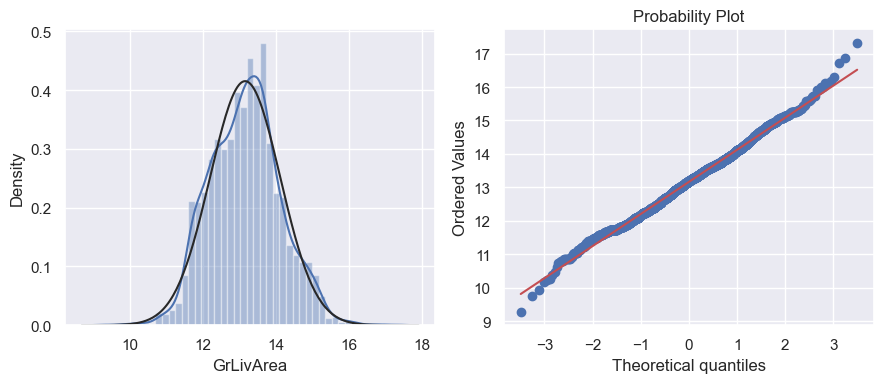

In [23]:
# variable under investigation
var = 'GrLivArea'

# Mode of the variable
var_mode = all_data[var].mode()[0]

# ratio of the first two most frequent values
vals = all_data[var].value_counts().values[:2].tolist()
ratio = vals[0]/vals[1]

# Print kurtosis, skew, mode(with percentage of data it occupies) and ratio of the variable
print(f"Skew: {all_data[var].skew():.2f}")
print(f"Kurtosis: {all_data[var].kurt():.2f}")
print(f'Mode: {var_mode:.2f} ({(100*all_data[var][all_data[var]==var_mode].size/all_data[var].size):.2f}%)')
print(f'Ratio: {ratio:.1f}')

fig, ax = plt.subplots(1,2, figsize=(9,4))

sns.distplot(all_data[var], fit=norm, ax=ax[0])
res = probplot(all_data[var], plot=ax[1])

fig.tight_layout()

Now it looks much more normal than it was before.

Now let's append the updated measurements to the old ones to use the resulting dataframe for visualization of the difference.

In [24]:
# updated skew and kurtosis
measures_upd = pd.DataFrame(data = {'Before/After':'After tarnsform',
                                'Skew':all_data[numerical].skew(),
                                'Kurtosis':all_data[numerical].kurt()},
                       ).sort_values(by='Skew', ascending=False)

# Append the updated measurments to the old one
measures = pd.concat([measures, measures_upd], axis=0)

Draw the barplot that shows the difference of skewness and kurtosis before and after the proccessing.

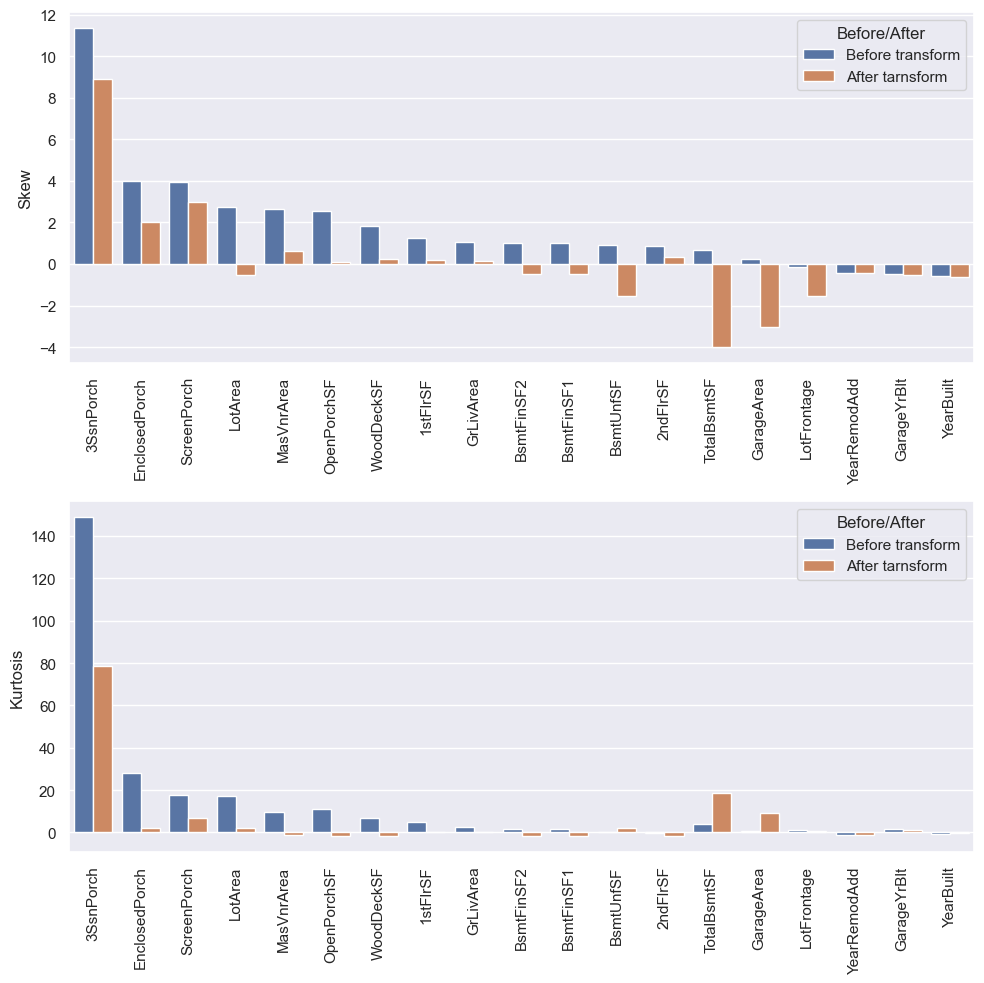

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

sns.barplot(x=measures.index, y=measures.Skew, hue=measures['Before/After'], ax=ax[0])
sns.barplot(x=measures.index, y=measures.Kurtosis, hue=measures['Before/After'], ax=ax[1])

fig.tight_layout()

As can be seen from the barplot removing outliers and boxcox transformation the features generally reduced thier skewness and kurtosis and, as the result, the distributions for the numeric features are closer to normal.

Now it's turn for the second problem. We remove near-zero variance elements out of the data set.

In [26]:
# Drop near-zero variance features
all_data = all_data.drop(['3SsnPorch', 'ScreenPorch'], axis=1)

In order to prevent underfitting we enrich our dataset by combining some of the features into the new ones. That will help our models to learn more complex functions which can improve accuracy of the models.

In [27]:
all_data['Total_Home_Quality'] = all_data['OverallQual'] + all_data['OverallCond']
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] +
                                 all_data['1stFlrSF'] + all_data['2ndFlrSF'])
all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                               all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))
all_data['AreaByCar'] = all_data['GarageArea']/all_data['GarageCars']
all_data['AreaByCar'] = all_data['AreaByCar'].fillna(0)

<a id = "TrainTestSplit"></a>

# Train/Test Split

The last step in the data preparation process is to get dummy variables and split the dataset back into train and test portions.

In [28]:
# one-hot encoding for nominal features
all_data = pd.get_dummies(all_data)
print(f'all_data: {all_data.shape}')

train = all_data[:ntrain]
test = all_data[ntrain:]

print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

all_data: (2907, 256)
train shape: (1448, 256)
test shape: (1459, 256)


<a id = "Modeling"></a>

# Modeling

Now as we have all data prepared we can start training our models.

In [29]:
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
import xgboost as xgb

In [30]:
X_train = train
Y_train = y_train

At this point we identify how we are going to estimate performace of models. For this purpose we utilize cross-validation approach. The idea is that we break our dataset into k parts. A model then trained using only k-1 parts and the acuracy is estimated on the remaining hold-out part. This process is repeated with the next part of the dataset taken for validation and the other k-1 parts for training. At the end we have k measures of accuracy which can be averaged to estimate model's overall performace.

In this notebook we use 5 Fold cross-validation.

In [31]:
# 5Fold cross-validation strategy
def rmse_cv(model, X, Y):
    return np.sqrt(-cross_val_score(model, 
                                    X, 
                                    Y, 
                                    scoring="neg_mean_squared_error" 
                                    ))

<a id = "Setup"></a>

## Models Setup

Variable **scores** will store scores of our models.

In [32]:
scores = dict()

**Ridge Regression**

Using RidgeCV class from scikit-learn we identified the best alpha for the training set.
    
    alpha = 13

In [33]:
# Ridge Regression
ridge = make_pipeline(RobustScaler(), Ridge(alpha=13))
score = rmse_cv(ridge, X_train, Y_train)
scores['ridge'] = score.mean()
print(f'RMSE: {score.mean()}')

RMSE: 0.1146202130768185


**Lasso Regression**

Using LassoCV class from scikit-learn we identified the best alpha for the training set.
    
    alpha = 0.0007

In [34]:
# Lasso Regression
lasso = make_pipeline(RobustScaler(),Lasso(alpha=0.0007))
score = rmse_cv(lasso, X_train, Y_train)
scores['lasso'] = score.mean()
print(f'RMSE: {score.mean()}')

RMSE: 0.11231415454952867


**ElasticNet Regression**

Using ElasticNetCV class from scikit-learn we identified the best alpha and l1 ratio for the training set.

    Best l1_ratio : 1.0
    Best alpha : 0.0006

In [35]:
elnet = make_pipeline(RobustScaler(),ElasticNet(alpha=0.0006, l1_ratio=1.0))
score = rmse_cv(elnet, X_train, Y_train)
scores['elnet'] = score.mean()
print(f'RMSE: {score.mean()}')

RMSE: 0.1121808955508137


**XGBoost**

Using GridSearchCV class from scikit-learn we identified the parameters for the training set.
    
    gamma=0.0468
    learning_rate=0.05 
    max_depth=3
    min_child_weight=1.7817
    n_estimators=2200
    reg_alpha=0.4640
    reg_lambda=0.8571
    subsample=0.5213

In [36]:
xgb = xgb.XGBRegressor(gamma=0.0468, 
                            learning_rate=0.05, 
                            max_depth=3, 
                            min_child_weight=1.7817, 
                            n_estimators=2200,
                            reg_alpha=0.4640, 
                            reg_lambda=0.8571,
                            subsample=0.5213,
                          )
score = rmse_cv(xgb, X_train, Y_train)
scores['xgb'] = score.mean()
print(f'RMSE: {score.mean()}')

RMSE: 0.11507514245137625


**SVM**

Using GridSearchCV class from scikit-learn we identified the parameters for the training set.

    C = 20
    epsilon = 0.008
    gamma=0.0003


In [37]:
svm = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))
score = rmse_cv(svm, X_train, Y_train)
scores['svm'] = score.mean()
print(f'RMSE: {score.mean()}')

RMSE: 0.14173394486064497


**Gardient Boosting**

Using GridSearchCV class from scikit-learn we identified the parameters for the training set.

    n_estimators=6000,
    learning_rate=0.01,
    max_depth=4,
    max_features='sqrt',
    min_samples_leaf=15,
    min_samples_split=10,
    loss='huber',
    random_state=42

In [38]:
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42) 
score = rmse_cv(gbr, X_train, Y_train)
scores['gbr'] = score.mean()
print(f'RMSE: {score.mean()}')

RMSE: 0.11306262649281965


**Stacking Ensemble**

As can be seen our models showed quite good scores but we want to go even further. In order to improve the accuracy we apply Stacking Ensemble algorithm. The basic idea is that our model consists two levels:

   1. Base models
   2. Meta model
   
Base models fit on the trainig data and the result are passed to meta-model which is in its turn learns how to best combine predictions from the base models.

For the base models we take all models we set up above and for the meta-model we select Lasso regression as it showed the highest score on the dataset.

In [39]:
# Base models
level0 = [('ridge', ridge),
         ('lasso', lasso),
         ('ElasticNet', elnet),
         ('XGBoost', xgb),
         ('SVM', svm),
         ('GBR', gbr)]

stacked_reg = StackingRegressor(estimators=level0, final_estimator=lasso)

score = rmse_cv(stacked_reg, X_train, Y_train)
scores['stacked'] = score.mean()
print(f'RMSE: {score.mean()}')

RMSE: 0.1079431034558691


Awesome! The score is improved showing that Stacked Ensemble worked for us.

<a id = "fit"></a>

## Fitting The Models

Now let's fit the models on the trainig data

In [40]:
ridge_fit = ridge.fit(X_train, Y_train)

In [41]:
lasso_fit = lasso.fit(X_train, Y_train)

In [42]:
elnet_fit = elnet.fit(X_train, Y_train)

In [43]:
xgb_fit = xgb.fit(X_train, Y_train)

In [44]:
svm_fit = svm.fit(X_train, Y_train)

In [45]:
gbr_fit = gbr.fit(X_train, Y_train)

In [46]:
stacked_reg_fit = stacked_reg.fit(X_train, Y_train)

Though it's already obvious which model performes best let's visualize RMSE for all models on a graph.

<AxesSubplot:>

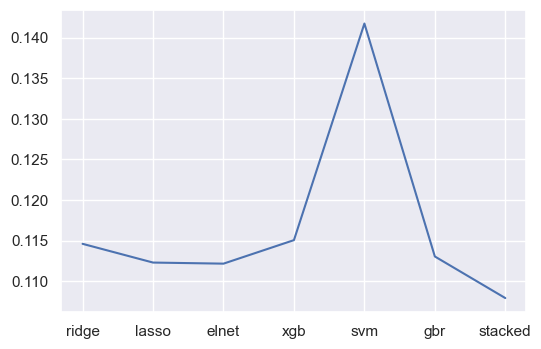

In [47]:
sns.lineplot(data=scores,
             x=scores.keys(), 
             y=scores.values())

According to the scores the stacked regressor has to lowest cross-validation error, thus we select it for the final submission.

<a id = "submit"></a>

# Submisson

In [49]:
sub = pd.DataFrame()

# Reverse log transformation with np.expm function 
sub['Id'] = test_ID
sub['SalePrice'] = np.expm1(stacked_reg_fit.predict(test.values))

# Save submission to csv file 
sub.to_csv('final_submission.csv',index=False)